# **Pamcrash baseline model**

The goal of this Notebook is to provide a baseline solution for the Challenge to help beginners iterate from a working and ready-to-use solution.

Made by Hamza Jebbar (DIRE) - November 2020

Last Update: January 25, 2021

In [ ]:
%%bigquery train_df
SELECT 
*
FROM
  `challenge.training_data`

### **Loading the libraries required for the analysis and plots**

Install machine learning libraries if they're not already there on your system.
Notice how you can run system commands by starting the line with an exclamation mark. In case the output is "pip3 not found", try and replace it with "pip"

In [ ]:
!pip3 install xgboost
!pip3 install lightgbm

     |████████████████████████████████| 157.5 MB 45 kB/s s eta 0:00:01  |▉                               | 3.9 MB 9.6 MB/s eta 0:00:17     |██████████████▍                 | 71.0 MB 12.2 MB/s eta 0:00:08     |███████████████████▍            | 95.6 MB 13.7 MB/s eta 0:00:05     |█████████████████████           | 103.4 MB 13.7 MB/s eta 0:00:04     |█████████████████████████▏      | 123.7 MB 13.7 MB/s eta 0:00:03     |███████████████████████████▏    | 133.9 MB 13.7 MB/s eta 0:00:02     |█████████████████████████████   | 143.1 MB 15.6 MB/s eta 0:00:01     |███████████████████████████████▊| 155.9 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 8.2 MB/s eta 0:00:01


In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib
from matplotlib import pyplot
import seaborn as sns

%matplotlib inline

## **Data preprocessing**

### **Load the data and take a quick look at the various columns**

For a more thorough analysis, please refer to "Analyze Dataset.ipynb"

In [ ]:
df = train_df.drop(["JOBID","DAY","HOUR","TZC_FINAL"], axis=1)
df.head()

,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK_NTNU,MBS,RUNEND,TIMESTEP,NBNODES,NBELEM1D,NBELEM2D,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME,ELAPSEDTIME
0,2018.0.1,POLE,1,YES,NO,NO,NO,110.01,0.00050,4507694,14570,4037272,1570802,HPC3,8.0,288,446.00,15000
1,2018.0.1,POLE,1,YES,NO,NO,NO,110.01,0.00050,4507694,14570,4037272,1570802,HPC3,8.0,288,446.00,15600
2,2018.0.1,POLE,1,YES,NO,NO,NO,110.01,0.00050,4507694,14570,4037272,1570802,HPC3,8.0,288,446.00,14600
3,2018.0.1,PEDESTRIAN,1,NO,NO,NO,NO,40.68,0.00050,1647532,3760,1673587,103822,HPC3,1.0,36,74.70,4510
4,2016.05,UNKNOWN,1,YES,NO,NO,NO,50.00,0.00005,174111,0,173261,0,HPC1,2.0,48,4.42,4060


### **Encoding the categorical columns**
In order to be able to use the categorical columns, we must encode their values and transform them into numerical values.

For example [YES, NO] would be [1, 0]



In [ ]:
numerical = list(df.describe().columns)
categorical = [col for col in df.columns if col not in numerical]
encoders = {}
for column in categorical:
  encoder = LabelEncoder().fit(df[column])
  df[column] = encoder.transform(df[column])
  encoders[column]=encoder
df.head()

,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK_NTNU,MBS,RUNEND,TIMESTEP,NBNODES,NBELEM1D,NBELEM2D,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME,ELAPSEDTIME
0,5,5,1,1,0,0,0,110.01,0.00050,4507694,14570,4037272,1570802,2,8.0,288,446.00,15000
1,5,5,1,1,0,0,0,110.01,0.00050,4507694,14570,4037272,1570802,2,8.0,288,446.00,15600
2,5,5,1,1,0,0,0,110.01,0.00050,4507694,14570,4037272,1570802,2,8.0,288,446.00,14600
3,5,4,1,0,0,0,0,40.68,0.00050,1647532,3760,1673587,103822,2,1.0,36,74.70,4510
4,2,9,1,1,0,0,0,50.00,0.00005,174111,0,173261,0,0,2.0,48,4.42,4060


### **Preparing the data**
We extract the output y "ELAPSEDTIME" from the input X.
Due to the big difference in the columns scale, we choose to scale the data using MinMaxScaler so that all the columns values will be between 0 and 1. This results in all the columns having the same effect on the output result.

In [ ]:
y = df["ELAPSEDTIME"]
X = df.drop(["ELAPSEDTIME"], axis=1)
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(data = scaler.transform(X), columns = X.columns)
# split the data into two categories, one for training and the other for testing
X_train_sc, X_test_sc, _, _ = train_test_split(X_scaled, y, test_size=0.33, random_state=42)
# We do the same split on the unscalled data, we'll use these ones later for the plots
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# Display the first samples of the dataset
X_scaled.head()

,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK_NTNU,MBS,RUNEND,TIMESTEP,NBNODES,NBELEM1D,NBELEM2D,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME
0,0.555556,0.5,0.0,1.0,0.0,0.0,0.0,0.001740,0.016634,0.461400,0.12520,0.420116,0.237247,1.0,1.000000,1.000000,0.145152
1,0.555556,0.5,0.0,1.0,0.0,0.0,0.0,0.001740,0.016634,0.461400,0.12520,0.420116,0.237247,1.0,1.000000,1.000000,0.145152
2,0.555556,0.5,0.0,1.0,0.0,0.0,0.0,0.001740,0.016634,0.461400,0.12520,0.420116,0.237247,1.0,1.000000,1.000000,0.145152
3,0.555556,0.4,0.0,0.0,0.0,0.0,0.0,0.000639,0.016634,0.168606,0.03231,0.174153,0.015681,1.0,0.000000,0.000000,0.024189
4,0.222222,0.9,0.0,1.0,0.0,0.0,0.0,0.000787,0.001633,0.017772,0.00000,0.018029,0.000000,0.0,0.142857,0.047619,0.001293


## **Creating a prediction model**

First of all let's define a function that computes three metrics that we'll use next to evaluate our models.

**RMSE**: root-mean-square deviation is a metric that computes the quadratic mean of the difference between the predicted values and the observed ones.

**MAE**: mean absolute error computes the absolute error between the predicted values and the observed ones.

**R2_score**: a score between 0 and 1 that indicates to which degree tha input variables explain the output.

The smaller RMSE and MAE and the bigger R2_score, the better the model.

In [ ]:
def compute_metrics(y,y_pred):
  RMSE = mean_squared_error(y, y_pred, squared=False)
  MAE = mean_absolute_error(y, y_pred)
  R2 = r2_score(y,y_pred)
  return RMSE, MAE, R2, "RMSE: "+str(round(RMSE,4))+"   |   MAE: "+str(round(MAE,4))+"   |   R2: "+str(round(R2,4))+"  |   size: "+str(len(y))

### **First try : LightGBM**
We split the data into two categories, a training set that we feed to the model, and a test set to evaluate it.

We start by creating an instance of the model, train it, then use the predict function to make the prediction and the r2_score metric to evaluate the model's accuracy.

In [ ]:
lgbm = LGBMRegressor()
# Example with tweaking parameters
# lgbm = LGBMRegressor(n_estimators=300, learning_rate=0.3, reg_lambda=1)
# Train the model
lgbm.fit(X_train_sc, y_train)
# Print the model results
print("LGBM:")
RMSE, MAE, R2, ALL = compute_metrics(lgbm.predict(X_train_sc), y_train)
print("Results on training data: "+ALL)
RMSE, MAE, R2, ALL = compute_metrics(lgbm.predict(X_test_sc), y_test)
print("Results on test data: " + ALL)

LGBM:
Results on training data: RMSE: 4796.2302   |   MAE: 2436.7958   |   R2: 0.93  |   size: 119410
Results on test data: RMSE: 4952.9299   |   MAE: 2486.7764   |   R2: 0.9244  |   size: 58814


### **Second Try: XGBoost**

This time, we try to use the XGBoost model to compare its results with the previous one.

In [ ]:
xgb1 = XGBRegressor()
xgb1.fit(X_train_sc, y_train)
print("XGBOOST:")
RMSE, MAE, R2, ALL = compute_metrics(xgb1.predict(X_train_sc), y_train)
print("Results on training data: " + ALL)
RMSE, MAE, R2, ALL = compute_metrics(xgb1.predict(X_test_sc), y_test)
print("Results on test data: " + ALL)

XGBOOST:
Results on training data: RMSE: 3383.03   |   MAE: 1669.6654   |   R2: 0.9669  |   size: 119410
Results on test data: RMSE: 3747.7144   |   MAE: 1785.415   |   R2: 0.9588  |   size: 58814


####**Comparing the metrics**

At first sight and based on the evalutation metrics, we can easily conclude that the LightGBM model is doing much better than XGBoost and therefore should be selected.

However, further analysis (that won't be detailed in this notebook) have shown that XGBoost can do better with some **Hyperparameter Tuning** (Next section) whilst LGBM's performance decreases, and thus we choose to proceed with XGBoost for the rest of the notebook.

### **XGBoost Regressor and the Hyperparameter tuning**
We choose to use the XGBoost Regressor model to solve this problem.
Since XGBoost has many input parameters (called "hyperparameters"), we'll iterate on them to find the combination which yields the best results. This is called "hyperparameter tuning".

We use the GridSearch method to tune these hyperpameters. For each one, we provide a number of values to be tested using the Kfold method.

KFold is a cross-validation method that splits randomly the training data to a number of partitions, and each time a partition will be used for the test while the others serve as training data. For each combination of hyperparameters, the final score is the mean of all the scores computed.

In [ ]:
model = XGBRegressor()
# Among the possible hyperparameters, we chose to iterate over 2: n_estimators and learning_rate
# n_estimators is the number of gradient boosting trees
# learning_rate is the step taken by the optimization algorithm on each iteration
# You can try to add more parameters or possible values and check if it gives better results
n_estimators = [10, 200, 300]
learning_rate = [0.01, 0.1, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators) ## hyperparameter's dictionary
kfold = KFold(n_splits=4, shuffle=True, random_state=7) ## n_splits: number of partitions after the split
grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
print("\nAll tests:")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975499 using {'learning_rate': 0.3, 'n_estimators': 300}

All tests:
-0.818905 (0.005013) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.842175 (0.003933) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.896276 (0.003308) with: {'learning_rate': 0.01, 'n_estimators': 300}
0.595743 (0.003168) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.954853 (0.001826) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.962302 (0.001925) with: {'learning_rate': 0.1, 'n_estimators': 300}
0.898347 (0.003157) with: {'learning_rate': 0.3, 'n_estimators': 10}
0.971272 (0.001420) with: {'learning_rate': 0.3, 'n_estimators': 200}
0.975499 (0.001167) with: {'learning_rate': 0.3, 'n_estimators': 300}


**Interpreting the results**

As we can see, the combination : n_estimators=300, learning_rate=0.3 gives the best results and thus will be chosen for the model.

**Plotting the curve**

This curve shows the evolution of the model's precision with each change in the hyperparameter. On the x-axis we have the number of estimators, and the y-axis represents the R2_score. The best value is 1 (100% accuracy) and the worst is 0.

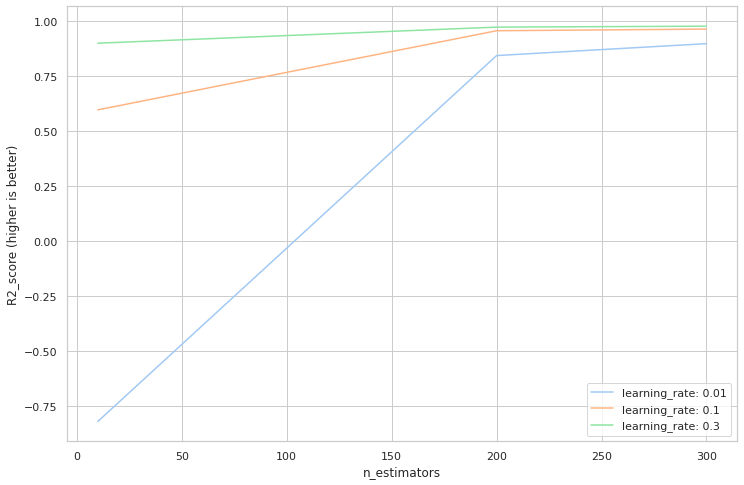

In [ ]:
# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
pyplot.figure(figsize=(12,8))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
ax = pyplot.gca()
sns.set_style('whitegrid')
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('R2_score (higher is better)')
pyplot.show()

## **Evalutating the model's results**

After choosing our best hyperparameters and training the model, let's evaluate its results on the test set.

In [ ]:
# We create a new DataFrame that we'll use for the plots
data = pd.DataFrame(data=X_test.copy(), columns=X.columns)
data["ELAPSEDTIME"] = y_test
data["Y_PRED"] = grid_result.predict(X_test_sc)
data["residuals"] = data["Y_PRED"] - data["ELAPSEDTIME"]
data["delta_all"] = 100 * (data["Y_PRED"] - data["ELAPSEDTIME"]) / data["ELAPSEDTIME"]
data["delta"] = data["delta_all"].apply(abs)
# We transform the values of the "PERFORMANCE" column from numerical [0,1...] to categorical
data["PERFORMANCE"] = encoders["PERFORMANCE"].inverse_transform(data["PERFORMANCE"])
data.head()

,VERSION,PERFORMANCE,PRECISION,MPLINK,NTNU,MPLINK_NTNU,MBS,RUNEND,TIMESTEP,NBNODES,...,NBELEM3D,CLUSTER,NBSERVERS,NBCORE,DATACHECK_TIME,ELAPSEDTIME,Y_PRED,residuals,delta_all,delta
42031,5,UNKNOWN,1,1,0,0,0,150.10,0.0004,446255,...,435,0,2.0,48,15.5,6170,6079.078125,-90.921875,-1.473612,1.473612
42122,2,UNKNOWN,1,1,0,0,0,60.00,0.0005,1062682,...,10420,0,2.0,48,32.6,3670,1889.353516,-1780.646484,-48.518978,48.518978
50976,2,UNKNOWN,1,1,0,0,0,180.01,0.0005,1011007,...,19677,0,2.0,48,34.8,12200,12836.043945,636.043945,5.213475,5.213475
57319,2,UNKNOWN,1,1,0,0,0,85.00,0.0005,286954,...,203771,0,2.0,48,12.3,6520,5001.632324,-1518.367676,-23.287848,23.287848
81044,5,UNKNOWN,1,0,0,1,0,60.01,0.0005,6179207,...,1387943,2,5.0,180,514.0,10900,10864.006836,-35.993164,-0.330213,0.330213


**Plotting the average error per servers' number**

Plotting a curve of the average %error as a function of the servers' number can give us an idea about the model's predictions precision for each number of servers.

In [ ]:
def plot_line(data, x="NBSERVERS", y="delta", y_pred="Y_PRED", h=None, s=None):
  # Plotting the curve of the average error in % per number of servers
  sns.set_style('whitegrid')
  g = sns.relplot(x=x, y=y, hue=h, style=s, ci=None, kind="line", data=data)
  g.fig.autofmt_xdate()
  g.fig.set_size_inches(12, 8)
  axes = g.axes.flatten()
  RMSE, MAE, R2, ALL = compute_metrics(data["ELAPSEDTIME"], data[y_pred])
  print(ALL)
  axes[0].set_title(ALL+"\n"+"Servers' number frequency:"+str(data[x].value_counts().to_dict()))
  axes[0].set(xlabel="Servers number", ylabel="Error in % (lower is better)")

RMSE: 2438.5391   |   MAE: 1159.0616   |   R2: 0.9836  |   size: 58814


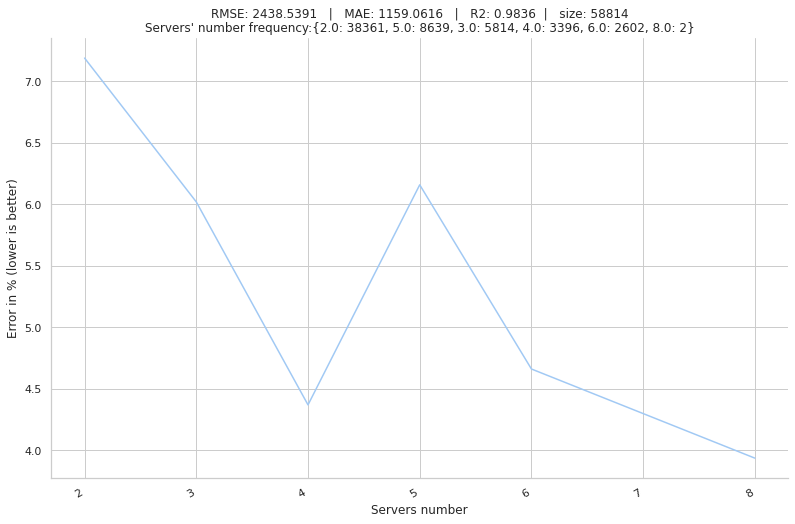

In [ ]:
plot_line(data)

**Error categories in a histogram**

We transform the error column from a continuous variable to a discretized variable, the value of which will belong to a category (for exemple ]15%,30%[ error). This will help us determine the density of each category.

In [ ]:
def plot_hist(data,x="delta_disc",color="blue",size_x=12,size_y=8):
  sns.set_style('whitegrid')
  g = sns.displot(data=data, x=x, color=color, discrete=True)
  axes = g.axes.flatten()
  g.fig.set_size_inches(size_x, size_y)
  axes[0].set_ylabel("Errors' Density")
  axes[0].set_xlabel("Errors' Categories")
  return axes[0]

In [ ]:
def discretize(data,bins):
  data = np.asarray(data)
  data = np.digitize(data,bins)
  return data

Text(0.5, 1.0, "RMSE: 2438.5391   |   MAE: 1159.0616   |   R2: 0.9836  |   size: 58814\n{0: ']-inf,-50%[', 1: ']-50%,-30%[', 2: ']-30%,-15%[', 3: ']-15%,15%[', 4: ']15%,30%[', 5: ']30%,50%[', 6: ']50%,+inf%['}")

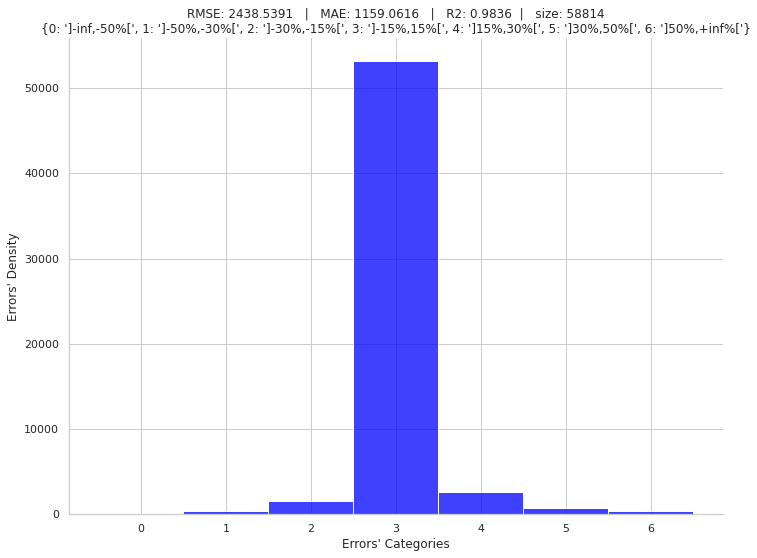

In [ ]:
data["delta_disc"] = discretize(data["delta_all"],[-50,-30,-15,15,30,50])
axes = plot_hist(data)
RMSE,MAE,R2,ALL = compute_metrics(data["ELAPSEDTIME"], data["Y_PRED"])
dic = {0:"]-inf,-50%[",1:"]-50%,-30%[",2:"]-30%,-15%[",3:"]-15%,15%[",4:"]15%,30%[",5:"]30%,50%[",6:"]50%,+inf%["}
axes.set_title(ALL+"\n"+str(dic))

**Plotting the prediction as a function of the ground truth**

This plot will help us see how far our predictions were from the ground truth.

<AxesSubplot:xlabel='ELAPSEDTIME', ylabel='ELAPSEDTIME'>

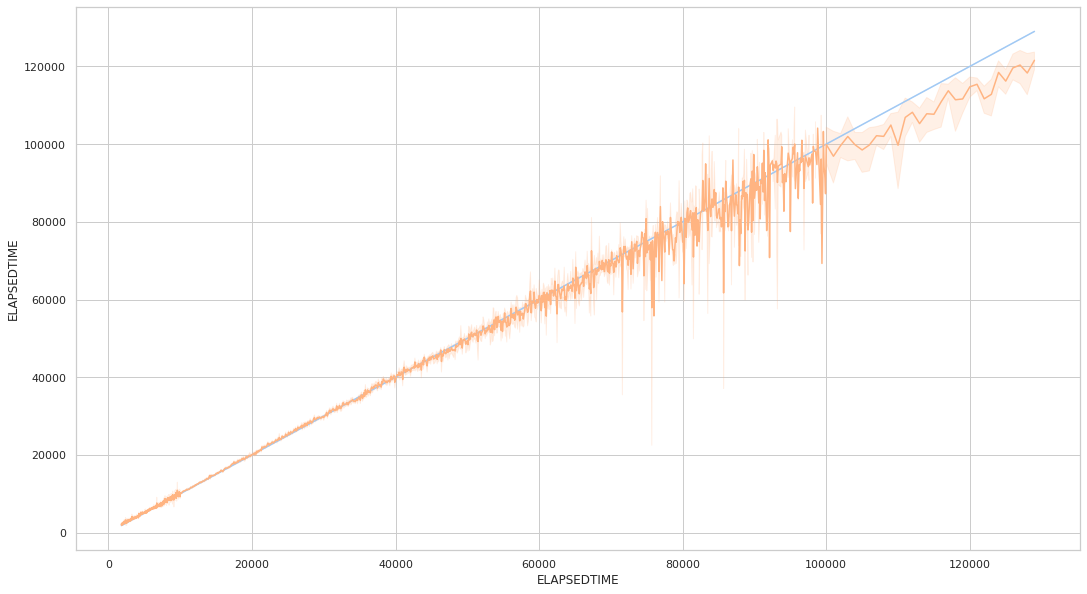

In [ ]:
fig, ax = pyplot.subplots()
fig.set_size_inches(18, 10)
sns.lineplot(x="ELAPSEDTIME", y="ELAPSEDTIME", data=data)
sns.lineplot(x="ELAPSEDTIME", y="Y_PRED", data=data)


As you can see, error is low when ELAPSEDTIME is lower than about 70.000 then things start to go wild.

We can arguably attribute the increase in the prediction's error when ELAPSEDTIME is bigger than 70000 to an unbalance in ELAPSEDTIME's values distribution, as we can see in the histogram bellow, the density of ELAPSEDTIME values becomes smaller and smaller for the values >70000.

**Boxplot**

The boxplot helps us see the errors' distribution for each type of simulation (column "PERFORMANCE").

The first line of the box represents 25% of the population, the second 50% and the third 75%,  the closer they are to the 0% line, the better the model.

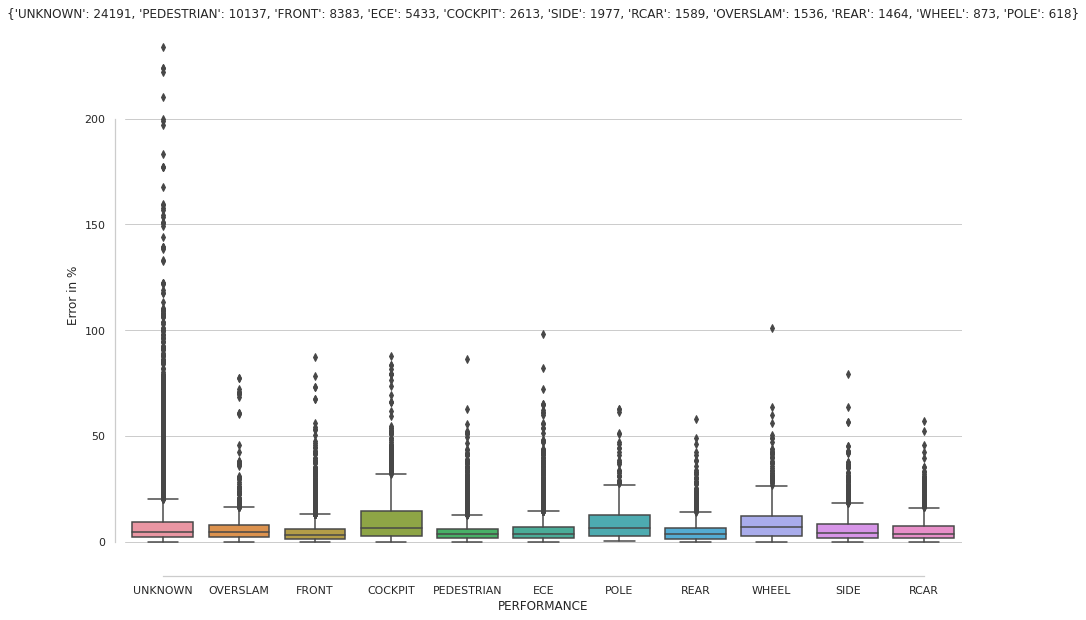

In [ ]:
## This line's job is to delete the rows that have an error >500%, they're called the OUTLAYERS
## We delete them only to have a better view at what the boxplot looks like
## We do not recommend doing that in a real project
data = data[~(data["delta"]>500)]
################
sns.set_theme(style="ticks", palette="pastel")
sns.set_style('whitegrid')
# Draw a nested boxplot to show bills by day and time
g = sns.boxplot(x="PERFORMANCE", y="delta", data=data)
g.set(ylabel='Error in %')
axes = g.axes
axes.figure.set_size_inches(15, 10)
axes.set_title(data["PERFORMANCE"].value_counts().to_dict())
sns.despine(offset=10, trim=True)

**Joint Plot with KDE**

The Kernel Density Estimate allows us to have a good idea about the density of our variables, we can see that we have a lot of data centered around the 20.000 value (ELAPSEDTIME axis) with 0 residuals/errors (residuals axis), meaning that our model's prediction is close to the ground truth.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


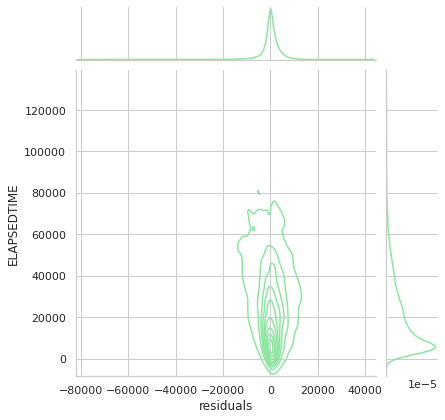

In [ ]:
sns.jointplot('residuals', 'ELAPSEDTIME', data=data,
              kind="kde", color="g");

**Saving the model**

We can save the model using pickle, but in order to be able to use it, we need to save the encoder and scaler that we used on the data as well. That will allow us to apply the same preprocessing on the data that we will predict in the future.

In [ ]:
import pickle
with open('label_encoder.pkl', 'wb') as output:
    pickle.dump(encoders, output, pickle.HIGHEST_PROTOCOL)
with open('scaler.pkl', 'wb') as output:
    pickle.dump(encoders, output, pickle.HIGHEST_PROTOCOL)
with open('model.pkl', 'wb') as output:
    pickle.dump(grid_result, output, pickle.HIGHEST_PROTOCOL)

## **Predicting the competition's data**

This section is reserved for you, you can choose a model and train it using the methods that we used in the sections above, then make a prediction on the data that we will provide for you.

### Preprocessing function:

This preprocessing method will help you prepare your data for prediction. Of course you're not obligated to use it and you can create your own function.

In [ ]:
def prepare_data(df,encoders,scaler):
  numerical = list(df.describe().columns)
  categorical = [col for col in df.columns if col not in numerical]
  for column in categorical:
    df[column] = encoders[column].transform(df[column])
  X_scaled = pd.DataFrame(data = scaler.transform(df), columns = df.columns)
  return X_scaled

In [ ]:
# In this cell you'll choose your model and make the prediciton, we loaded the data for you
df = pd.read_csv("https://drive.google.com/u/0/uc?id=15QutxBe6nQxtcUN0crCzmyz43TpeGyCu&export=download", sep=";")
competition = df.drop(["JOBID", "DAY", "HOUR"], axis=1)

# Apply the same preprocessing methods you used on the training data on the competition data
# TO GO FURTHER, try and apply your own preprocessing workflow
X_competition = prepare_data(competition, encoders, scaler)

# Choose your model, or uncomment the second line to use our pretrained model to make the predictions
# TO GO FURTHER, try with a custom model built by yourself
model = grid_result

# Train your model here in case you created your own model
# Remeber, use on the training data the same preprocessing method you used on the competition data above
X_train = X
y_train = y

#Save your prediction here
df["prediction"] = model.predict(X_competition)

### **Saving the prediction**

This section is reserved to save your results in a file that you'll need to upload in the competition's application.

In [ ]:
from google.colab import files
data_comp = pd.DataFrame(data=df["JOBID"], columns=["JOBID"])
data_comp["PREDICTION"] = df["prediction"]
# Saving and downloading the prediction file
path = "prediction.csv"
data_comp.to_csv(path, index=False, sep=";")
files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>